<center>
    <h3> Real-Time Time Dependent Orbital Free Density Functional Theory with DFTpy</h3>
    <h3>Tutorial</h3>
</center>
<table>
  <tr>
      <td><p><h4>Rutgers University-Newark</h4></p><p>Dr Xuecheng Shao</p><p>Dr Kaili Jiang (Microsoft)</p><p>Dr. Bhaskar Rana</p><p>Jessica Martinez</p><p>Valeria Rios </p><p>Alina Umerbekova</p></td>
          <td><img src="../../2024/figures/logos/logo.jpg" width=800 /></td>
  </tr>
</table>

ASESMA 2025

## Goal: COmpute optical spectra with DFTpy
#### 1) Obtain a good initial density with LMGP (OESCF)
#### 2) Compute the Optical Spectra (plasmons) of a Mg<sub>8</sub> from a good initial density  
#### Challenge: Obtain the spectrum of your own cluster

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick
from dftpy.ions import Ions
from dftpy.formats import io
from dftpy.constants import Units
from dftpy.td.utils import calc_spectra_mu

In [3]:
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF

--2025-06-03 21:32:32--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
Resolving gitlab.com (gitlab.com)... 172.65.251.78
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839 [text/plain]
Saving to: ‘Mg8.vasp.2’

Mg8.vasp.2          100%[===================>]     839  --.-KB/s    in 0s      

2025-06-03 21:32:32 (80.0 MB/s) - ‘Mg8.vasp.2’ saved [839/839]

--2025-06-03 21:32:32--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF
Resolving gitlab.com (gitlab.com)... 172.65.251.78
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98081 (96K) [text/plain]
Saving to: ‘Mg_OEPP_PZ.UPF.2’

Mg_OEPP_PZ.UPF.2    100%[===================>]  95.78K  --.-KB/s    in 0.05s   

2025-06-03 21:32:33 (2.07 MB/s) - ‘Mg_OEPP_PZ.UPF.2’ saved [98081/98081]



### Read the vasp file with DFTpy

In [4]:
ions = io.read('Mg8.vasp', format='vasp', names=['Mg'])

### Create the PP list and the Grid
DirectGrid is a class object that represents a grid (Cell plus discretization)

In [5]:
PP_list = ['./Mg_OEPP_PZ.UPF']
grid = DirectGrid(ions.cell, spacing = 1.1)

In [6]:
grid.nr

array([36, 36, 32], dtype=int32)

### Define the functionals for OF-DFT

In [7]:
xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list)

setting key: Mg -> ./Mg_OEPP_PZ.UPF


### Represented a field on a grid
Write on the grid the initial electronic density

In [8]:
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

### Write the optimization options and build the class that handles the electron density optimization

In [9]:
optimization_options = {'econv' : 1e-11,'maxiter' : 100}

#### Run the optimization of the electronic density with TF0.2vW

In [10]:
ke = Functional(type='KEDF',name='TFvw', y=0.2)
totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)
opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')
rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.951916882520E+00      8.951917E+00    2.343046E+00    1       1       2.684712E-02    
!WARN: Change to steepest decent
1       -5.391241844465E+00     -1.434316E+01   1.315224E+00    1       3       5.571389E-02    
2       -6.787012645229E+00     -1.395771E+00   1.519794E-01    2       2       7.913613E-02    
3       -7.028248145499E+00     -2.412355E-01   1.639106E-02    5       3       1.257429E-01    
4       -7.058369908191E+00     -3.012176E-02   1.701910E-03    5       2       1.651659E-01    
5       -7.059908530812E+00     -1.538623E-03   1.781677E-04    3       2       1.946950E-01    
6       -7.060408861365E+00     -5.003306E-04   1.085856E-05    6       3       2.423599E-01    
7       -7.060419731847E+00     -1.087048E-05   1.330571E-06    4       3       2.810478E-01    
8       -7.060420451061E+00     -7.192140E-07   6.551728E-07    3       3       3.130379E-01  

In [11]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)

In [12]:
from dftpy.mixer.pulay import PulayMixer
pulay=PulayMixer(mp=None)

In [13]:
from dftpy.optimization import OESCF

In [14]:
vw = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vw, XC=xc, HARTREE=hartree, PSEUDO=pseudo)

kedf_emb = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho, mixer=pulay)

In [15]:
rho0 = opt.optimize_rho(guess_rho=rho, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -7.204194381864E+00     -7.204194E+00   9.995974E-01    1       1       4.762173E-03    
1       -7.529012586465E+00     -3.248182E-01   2.821877E-01    1       2       1.687407E-02    
2       -7.613763536066E+00     -8.475095E-02   1.327601E-01    1       2       2.830911E-02    
3       -7.668002787571E+00     -5.423925E-02   8.003215E-02    1       2       3.952789E-02    
4       -7.685169507877E+00     -1.716672E-02   4.264537E-02    1       2       5.141711E-02    
5       -7.693641935166E+00     -8.472427E-03   1.840731E-02    1       3       6.816792E-02    
6       -7.697651278215E+00     -4.009343E-03   1.091487E-02    1       3       8.474708E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.14483034768150968
Chemical potential (eV)  : -3.941034498804881
 OESCF--> iter=1     conv=1.600E-02 de=8.417E+00 energy=-8.417334E+00 time=9.197195E+00
S

In [96]:
rho0.write(filename="rho_lmgp.xsf", ions=ions)

# Time dependent part
### Remove the von Wäzecker KEDF
Change the KE functional in the total functional to Pauli functional, the laplacian is handled by the hamiltonian
$$
v_p(\mathbf{r},t) = v_{Ts}(\mathbf{r},t) - v_{vW}(\mathbf{r},t)
$$

##### Initialize the Time propagation from $n_{LMGP}(\mathbf{r})$
$$H(t) = H(t_0) + [\tilde{H}(t)-\tilde{H}(t_0)]$$
$$v_B(\mathbf{r},t) = v_B(\mathbf{r},t_0) + [\tilde{v}_B(\mathbf{r},t)-\tilde{v}_B(\mathbf{r},t_0)]$$
$$
[-\frac{1}{2}\nabla ^2 + v_B(\mathbf{r},t_0)]\phi_B(\mathbf{r},t_0) = \mu \phi_B(\mathbf{r},t_0) \rightarrow v_B(\mathbf{r},t_0) = \underbrace{\frac{1}{2}\frac{\nabla ^2 \phi_B(\mathbf{r},t_0)}{\phi_B(\mathbf{r},t_0)}}_{-v_{vW}[n(\mathbf{r},t_0)]} + \mu 
$$
$$
v_B(\mathbf{r},t) = -v_{vW}(\mathbf{r},t_0) + [\tilde{v}_s(\mathbf{r},t)+\tilde{v}_p(\mathbf{r},t)-\tilde{v}_s(\mathbf{r},t_0)-\tilde{v}_p(\mathbf{r},t_0)]
$$
$$
\therefore v_B(\mathbf{r},t) = -v_{vW}[n(\mathbf{r},t_0)] + [\tilde{v}_s(\mathbf{r},t)+\tilde{v}_p(\mathbf{r},t)-\tilde{v}_s[n(\mathbf{r},t_0)]-\tilde{v}_p[n(\mathbf{r},t_0)]]
$$

In [98]:
ke = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
ke.options.update({'y':0})
ke2 = Functional(type='KEDF',name='TFvW')
ke2.options.update({'y':0})

v_p = ke(rho0).potential
v_p2 = ke2(rho0).potential

v_ext = v_p - v_p2

In [99]:
from dftpy.functional.external_potential import ExternalPotential

In [100]:
ext = ExternalPotential(v=v_ext)
totalfunctional = TotalFunctional(KEDF=ke2, XC=xc, HARTREE=hartree, PSEUDO=pseudo)
totalfunctional.UpdateFunctional(newFuncDict={'EXT': ext})

### Verify Ground state
BUild the hamiltonian and diagonalize it to verify that the propagation starts with the correct initial density 

In [101]:
potential = totalfunctional(rho0).potential
H = Hamiltonian(v=potential)
eigval, psi_list = H.diagonalize(numeig=1)

In [102]:
psi_lmgp = np.sqrt(rho0)

In [103]:
N = (psi_lmgp*psi_lmgp).integral()

In [104]:
rho_h = N * (psi_list[0]*psi_list[0])

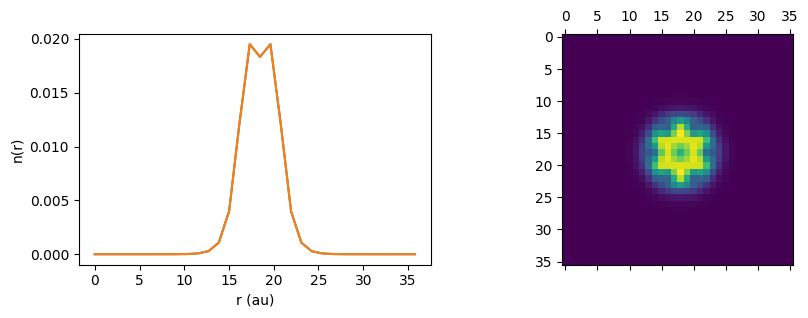

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_h[16,16,:].ravel()))
axs[0].plot(r, rho_h[15,15,:].ravel())
axs[0].plot(r, rho0[15,15,:].ravel())
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_h[:,:,15])

## Time propagation

In [106]:
from dftpy.constants import TIME_CONV, LEN_CONV, ENERGY_CONV
as2au = TIME_CONV['s']['au']*1e-18
bohr = LEN_CONV['Angstrom']['Bohr']
k = 0.01*bohr
interval = 1.0 * as2au
ha = ENERGY_CONV['Hartree']['eV']

In [107]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively

## Run with Crank Nicholson propagator

In [108]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential+v_ext)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        print("\r", end="")
        print(f"Progress: [{self.nsteps+1}/{self.max_steps}]", "|" * (self.nsteps*50 // self.max_steps), end="", flush=True)

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [113]:
max_steps = 5000
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

Progress: [5000/5000] |||||||||||||||||||||||||||||||||||||||||||||||||

False

In [114]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
mu = np.asarray(runner.dipole)

## Plot the dipole moment

Text(0, 0.5, 'Dipole Moment (au)')

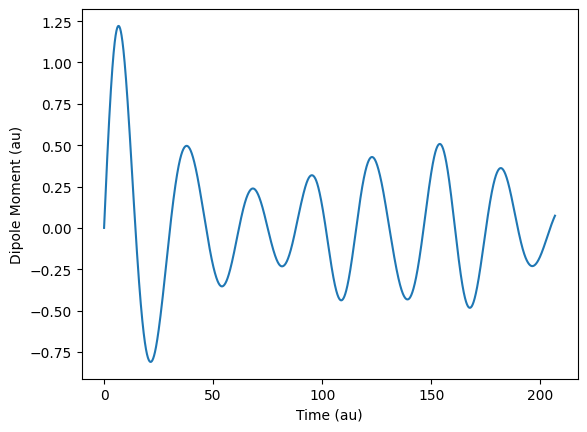

In [115]:
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

## Plot the optical spectra

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


(0.0, 20.0)

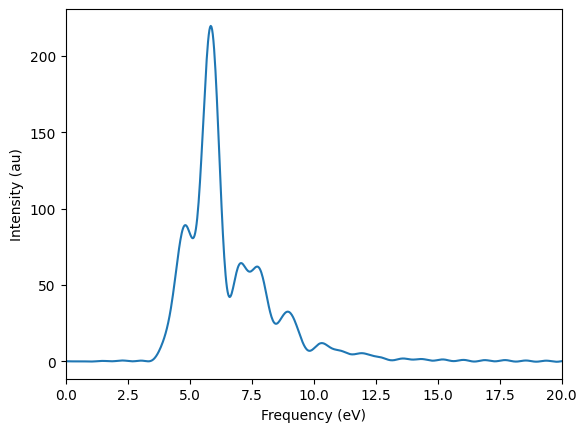

In [119]:
sigma = 0.03*(as2au**2)
omega, spectra = calc_spectra_mu(delta_mu, interval, sigma=sigma, kick=k)
plt.plot(omega*Units.Ha, spectra, '-')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 20)

## Challenge 

Calculate the optical spectra of your own cluster

### Add list of pseudos!!

### Build a cluster with ASE


In [32]:
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [2, 2, 2]
lc = 3.61000
atoms = FaceCenteredCubic('Mg', surfaces, layers, latticeconstant=lc)
atoms.set_cell([10,10,10])
atoms.wrap()
atoms.center(vacuum=10.0)

In [33]:
atoms.get_global_number_of_atoms()

19

In [34]:
import py3Dmol
from ase.build import bulk
from ase.io import write
from ase.constraints import FixBondLength
write('cluster.xyz',atoms)
v = py3Dmol.view(data=open('./cluster.xyz','r').read(), style='sphere',linked=False)

v.addUnitCell()
v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.